In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from collections import namedtuple

from definitions import ROOT_DIR
from unc.utils import load_info

plt.rcParams.update({'font.size': 18})

/Users/ruoyutao/Documents/uncertainty/venv/lib/python3.8/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
all_paths = {
    '2_linear': Path(ROOT_DIR, 'results', '2_linear'),
#     '2_nn':  Path(ROOT_DIR, 'results', '2_nn'),
    '2o_linear': Path(ROOT_DIR, 'results', '2o_linear'),
#     '2o_nn': Path(ROOT_DIR, 'results', '2o_nn')
    '2pb_linear': Path(ROOT_DIR, 'results', '2pb_linear'),
#     '2pb_nn': Path(ROOT_DIR, 'results', '2pb_nn'),
    '2t_nn': Path(ROOT_DIR, 'results', '2t_nn')

}

split_by = ['step_size', 'epsilon']
Args = namedtuple('args', split_by)


def moving_avg(x, mode='valid', w=100):
    return np.convolve(x, np.ones(w), mode=mode) / w

In [3]:
def process_dir(dir_path, split_by):
    all_results = {}
        
    for f in tqdm(list(dir_path.iterdir())):
        if not f.is_file() or f.suffix != '.npy':
            continue
        info = load_info(f)
        args = info['args'].item()
        
        hparams = Args(*tuple(args[s] for s in split_by))

        if hparams not in all_results:
            all_results[hparams] = []

#         all_results[hparams].append((info['episode_reward'], args))
        all_results[hparams].append((args, info['episode_reward'], f))


    
    return all_results

In [4]:
raw_data = {}

for key, v in all_paths.items():
    processed = process_dir(v, split_by)
    
    raw_data[key] = {}
    for hparams, ret in processed.items():
        rew_lst, arg_lst, f_lst = [], [], []
        for r in ret:
            rew_lst.append(r[1])
            arg_lst.append(r[0])
            f_lst.append(r[2])
        raw_data[key][hparams] = {'rewards': np.stack(rew_lst), 'args': arg_lst, 'paths': f_lst}

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

In [5]:
# Here we get our best hparams
all_best = {}
for key, res in raw_data.items():
    stats_list = []
    for args, rew_dict in res.items():
        # we take mean over both time and seeds
        stats_list.append((args, rew_dict['rewards'].mean(), rew_dict['rewards'], rew_dict['args'], rew_dict['paths']))
    all_best[key] = sorted(stats_list, key=lambda x: x[1])[-1]
all_best

{'2_linear': (args(step_size=0.001, epsilon=0.1),
  11.535973333333333,
  array([[ 9,  5,  6, ..., 10, 10, 11],
         [11,  7, 12, ..., 11, 13, 14],
         [ 4,  3,  3, ..., 11,  8, 12],
         ...,
         [ 3,  2,  2, ...,  9, 12, 13],
         [ 5, 13, 12, ..., 10, 12, 14],
         [10,  5,  2, ..., 14, 15, 12]]),
  [{'update_weight_interval': 1,
    'unnormalized_counts': False,
    'exploration': 'eps',
    'anneal_steps': 0,
    'p_prefilled': 0.0,
    'random_start': True,
    'blur_prob': 0.3,
    'algo': 'sarsa',
    'trunc': 10,
    'v_min': -10,
    'log_dir': PosixPath('/Users/ruoyutao/Documents/uncertainty/log/2_linear'),
    'atoms': 51,
    'po_degree': 0.0,
    'n_hidden': 5,
    'n_particles': -1,
    'results_fname': '5e48c7223c284bfc11524455dbd01ec6_Fri May  6 15:52:00 2022.npy',
    'rock_obs_init': 0.0,
    'k_rnn_hs': 1,
    'slip_prob': 0.0,
    'arch': 'linear',
    'same_k_rnn_params': False,
    'buffer_size': 20000,
    'results_dir': PosixPath('/Use

In [6]:
all_best['2t_nn'][4]

[PosixPath('/Users/ruoyutao/Documents/uncertainty/results/2t_nn/3b81a991e49748e5a676ea087cf9b014_Thu Jun 23 10:07:22 2022.npy'),
 PosixPath('/Users/ruoyutao/Documents/uncertainty/results/2t_nn/502fe57fdc648f0588fdba9a2d3f5aa7_Thu Jun 23 10:07:22 2022.npy'),
 PosixPath('/Users/ruoyutao/Documents/uncertainty/results/2t_nn/7abf373f82887b079fd0cd8b8e2e0a73_Thu Jun 23 10:07:22 2022.npy'),
 PosixPath('/Users/ruoyutao/Documents/uncertainty/results/2t_nn/40cff93791c3b0abe570b00b326dc17e_Thu Jun 23 10:07:22 2022.npy'),
 PosixPath('/Users/ruoyutao/Documents/uncertainty/results/2t_nn/d988ad02f939a98f60c5968345f516d4_Thu Jun 23 10:07:22 2022.npy'),
 PosixPath('/Users/ruoyutao/Documents/uncertainty/results/2t_nn/a60f09ba02f9190509cbaadd962961b2_Thu Jun 23 10:07:22 2022.npy'),
 PosixPath('/Users/ruoyutao/Documents/uncertainty/results/2t_nn/03cfb1ba95eb01e4b9f7ad454e0a9a74_Thu Jun 23 10:07:22 2022.npy'),
 PosixPath('/Users/ruoyutao/Documents/uncertainty/results/2t_nn/d6c03d2557b28380067d9f53147ffbd6_

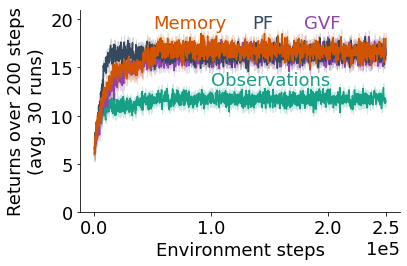

In [7]:
fig, ax = plt.figure(), plt.axes()
steps_per_eps = 200

selection = ['2_linear', '2t_nn', '2pb_linear']

plot_info = {
    '2_linear': {
        'color': '#16a085', 
        'label': {'x': 1e5, 'y': 13.2, 'text': 'Observations'}
    },
    
    '2o_linear': {
        'color': '#d35400',       
        'label': {'x': 0.5e5, 'y': 19.1, 'text': 'Memory'}
    },
    '2pb_linear': {
        'color': '#34495e', 
        'label': {'x': 1.35e5, 'y': 19.1, 'text': 'PF'}
    },
    '2t_nn': {
        'color': '#8e44ad', 
        'label': {'x': 1.8e5, 'y': 19.1, 'text': 'GVF'}
    },

}

lobster_results_path = Path(ROOT_DIR, 'results', 'lobster_results.pdf')
plotting_order = ['2_linear', '2t_nn', '2pb_linear', '2o_linear']

for k in plotting_order:
    v = all_best[k]
#     if k not in selection:
#         continue
    data = v[2]
    key = plot_info[k]['label']['text']
    color = plot_info[k]['color']
    x = np.arange(data.shape[1]) * steps_per_eps

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / np.sqrt(data.shape[0])

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)
    l_info = plot_info[k]['label']
    plt.text(l_info['x'], l_info['y'], l_info['text'], color=color, fontdict=dict(size=18))

ax.set_ylim(0, 21)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Returns over 200 steps\n(avg. 30 runs)")
ax.set_xticks([0, 1e5, 2e5, 2.5e5])


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.tight_layout()
# ax.set_title(f'Lobster Environment')


plt.savefig(lobster_results_path, bbox_inches='tight')
# plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

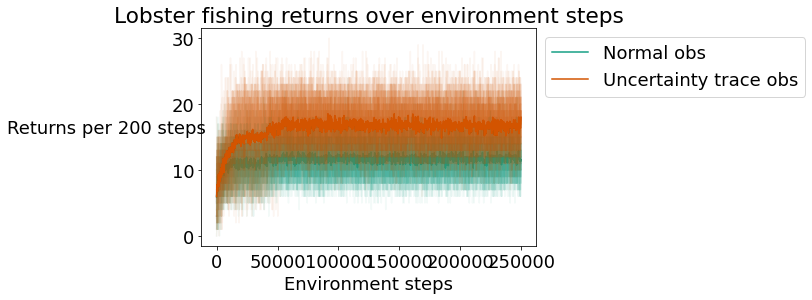

In [7]:
fig, ax = plt.figure(), plt.axes()
steps_per_eps = 200


for k, v in all_best.items():
    data = v[-1]
    key = plot_info[k]['label']
    color = plot_info[k]['color']
    x = np.arange(data.shape[1]) * steps_per_eps

    means = data.mean(axis=0)

    ax.plot(x, means, label=key, color=color)
    
    for y in data:
        ax.plot(x, y, color=color, alpha=0.05)



ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Returns per {steps_per_eps} steps", rotation=0, labelpad=65)
ax.set_title(f'Lobster fishing returns over environment steps')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

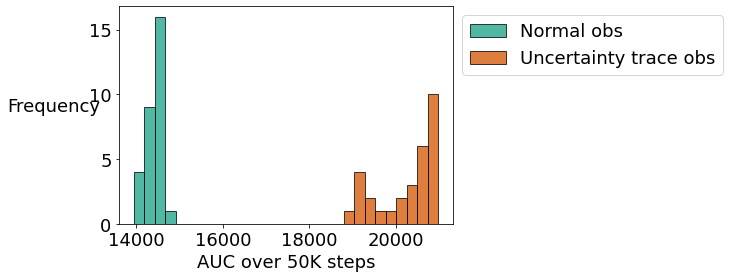

In [8]:
# we plot distribution over AUCs.
steps_per_eps = 200
fig, ax = plt.figure(), plt.axes()

all_aucs = {}
min_bin = float('inf')
max_bin = -float('inf')

for k, v in all_best.items():
    data = v[-1]
    aucs = data.sum(axis=-1)
    min_bin = min(min_bin, aucs.min())
    max_bin = max(max_bin, aucs.max())
    
bins = np.linspace(min_bin, max_bin, 30)

for k, v in all_best.items():
    data = v[-1]
    aucs = data.sum(axis=-1)
    color = plot_info[k]['color']
    key = plot_info[k]['label']
    
    ax.hist(aucs, bins=bins, color=color, label=key, alpha=0.75, edgecolor='black', linewidth=1)

ax.set_xlabel('AUC over 50K steps')
ax.set_ylabel(f"Frequency", rotation=0, labelpad=35)
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

In [67]:
aucs.min()

3760